# Capstone Project - The Battle of Neighborhoods

## Recommending Business ventures that are Most Lucrative Around a College or University Campus in the United States


This work studies venues around united states colleges and universities by utilizing foursqure API and clustering these venues using kmeans, then using wordcloud to show these venues clusters and recommending what business venture could be a lucrative business is most suited for a university campus

Load necessary libraries

In [1]:
#Import necessary libraries
import requests
import urllib.request
import time
#import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
import warnings
warnings.filterwarnings("ignore")

Load the campus geospatial data in json format

Please, notice that for convenience, I downloaded the files and placed it on the data.world server, so one could simply run the wget command to access the data.

In [2]:
!wget -q -O 'USCampuses.geojson' https://query.data.world/s/ga32mgxspcaxmuuhjqrfrdgdq5uija
print('file loaded')

file loaded


In [3]:
#import library for manipulating json
import urllib, json

In [4]:
with open('USCampuses.geojson') as f:

      x = json.load(f)

In [5]:
# Take a look at the json file, you will notice it is a nested json file
# print(x) # you could uncomment this if want to see the complete geojson file

In [6]:
y=x["features"]

In [7]:
y[0] # Let's view a part of the file

{'type': 'Feature',
 'properties': {'OBJECTID': 1,
  'GIS_ID': 'Univ_016',
  'NAME': 'Dominican House of Studies',
  'WEB_URL': 'http://www.dhs.edu',
  'ADDRESS': '487 MICHIGAN AVENUE NE',
  'Shape_Length': 753.6381321805197,
  'Shape_Area': 31647.8642746504},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-76.99777426477156, 38.92987942829586],
    [-76.99799166172988, 38.92979759341414],
    [-76.99952149721264, 38.931726115287375],
    [-76.99886138316563, 38.931990330584505],
    [-76.99848908868026, 38.93213934178816],
    [-76.99820310959065, 38.932253802361316],
    [-76.99809476545808, 38.932253800647345],
    [-76.99680523586355, 38.9302398795819],
    [-76.9970605779539, 38.93014447701139],
    [-76.99731591791934, 38.93004907388131],
    [-76.99767232676956, 38.929915907155646],
    [-76.99777426477156, 38.92987942829586]]]}}

We normalize our json file by parsing it into a pandas  dataframe 

In [8]:
# Import packages for json normalization
from pandas.io.json import json_normalize
df = pd.json_normalize(x["features"])

coords = 'geometry.coordinates'

df2 = (df[coords].apply(lambda r: [(i[0],i[1]) for i in r[0]])
           .apply(pd.Series).stack()
           .reset_index(level=1).rename(columns={0:coords,"level_1":"point"})
           .join(df.drop(coords,1), how='left')).reset_index(level=0)

df2[['latitude','longitude']] = df2[coords].apply(pd.Series)

df2

,index,point,geometry.coordinates,type,properties.OBJECTID,properties.GIS_ID,properties.NAME,properties.WEB_URL,properties.ADDRESS,properties.Shape_Length,properties.Shape_Area,geometry.type,latitude,longitude
0,0,0,"(-76.99777426477156, 38.92987942829586)",Feature,1,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864275,Polygon,-76.9978,38.9299
1,0,1,"(-76.99799166172988, 38.92979759341414)",Feature,1,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864275,Polygon,-76.998,38.9298
2,0,2,"(-76.99952149721264, 38.931726115287375)",Feature,1,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864275,Polygon,-76.9995,38.9317
3,0,3,"(-76.99886138316563, 38.931990330584505)",Feature,1,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864275,Polygon,-76.9989,38.932
4,0,4,"(-76.99848908868026, 38.93213934178816)",Feature,1,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864275,Polygon,-76.9985,38.9321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,27,10,"(-76.99578930337955, 38.94381443915008)",Feature,28,Univ_028,Marist College,http://www.marist.edu/,815 VARNUM STREET NE,402.157576,9002.704145,Polygon,-76.9958,38.9438
429,27,11,"(-76.99518109484549, 38.94347396941075)",Feature,28,Univ_028,Marist College,http://www.marist.edu/,815 VARNUM STREET NE,402.157576,9002.704145,Polygon,-76.9952,38.9435
430,27,12,"(-76.9949881862056, 38.94326909482264)",Feature,28,Univ_028,Marist College,http://www.marist.edu/,815 VARNUM STREET NE,402.157576,9002.704145,Polygon,-76.995,38.9433
431,28,0,"([-76.99837909696163, 38.940295753020074], [-7...",Feature,29,Univ_002,Catholic University of America,http://www.cua.edu/,620 MICHIGAN AVENUE NE,5629.610784,614563.690600,MultiPolygon,"[-76.99837909696163, 38.940295753020074]","[-76.99836315527294, 38.94029563062323]"


Select columns that could be useful for our analysis

In [9]:
campuses=df2[['properties.GIS_ID','properties.NAME','properties.WEB_URL','properties.ADDRESS',
              'properties.Shape_Length','properties.Shape_Area','latitude','longitude']]

Change column names to simple understandable names 

In [10]:
campuses.rename(columns = {'properties.GIS_ID':'GID_id','properties.NAME':'Name','properties.WEB_URL':'Web_url',
                              'properties.ADDRESS':'Address','properties.Shape_Length':'Shape_length',
                              'properties.Shape_Area':'Shape_area','latitude':'Latitude',
                              'longitude':'Longitude'}, inplace = True)

In [11]:
# Display five rows of our dataframe
campuses.head()

,GID_id,Name,Web_url,Address,Shape_length,Shape_area,Latitude,Longitude
0,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864275,-76.9978,38.9299
1,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864275,-76.998,38.9298
2,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864275,-76.9995,38.9317
3,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864275,-76.9989,38.932
4,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864275,-76.9985,38.9321


In [12]:
campuses = pd.read_csv('https://query.data.world/s/jkr7bbv5t7qebmmokhhbqgl3ahlxnk')

In [13]:
# Check the columns data type
campuses.dtypes

GID_id           object
Name             object
Web_url          object
Address          object
Shape_length    float64
Shape_area      float64
Latitude        float64
Longitude       float64
dtype: object

In [14]:
# Check last five rows
campuses.tail()

,GID_id,Name,Web_url,Address,Shape_length,Shape_area,Latitude,Longitude
437,Univ_028,Marist College,http://www.marist.edu/,815 VARNUM STREET NE,402.157576,9002.704145,-76.994988,38.943269
438,Univ_002,Catholic University of America,http://www.cua.edu/,620 MICHIGAN AVENUE NE,5629.610784,614563.690600,-76.998379,38.940296
439,Univ_002,Catholic University of America,http://www.cua.edu/,620 MICHIGAN AVENUE NE,5629.610784,614563.690600,-76.998363,38.940296
440,Univ_012,University of the District of Columbia,http://www.udc.edu/,4200 CONNECTICUT AVENUE NW,1560.382082,89377.984550,-77.065690,38.946394
441,Univ_012,University of the District of Columbia,http://www.udc.edu/,4200 CONNECTICUT AVENUE NW,1560.382082,89377.984550,-77.065092,38.945358


In [15]:
# Get only unique university name entries 
unique_campuses = campuses.drop_duplicates(subset=['Name'])

In [16]:
unique_campuses.shape # Check the shape

(30, 8)

In [17]:
# Check last five rows
unique_campuses.head()

,GID_id,Name,Web_url,Address,Shape_length,Shape_area,Latitude,Longitude
0,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864270,-76.997774,38.929879
12,Univ_023,Stanford in Washington,https://siw.stanford.edu/,2661 CONNECTICUT AVENUE NW,105.168729,448.839365,-77.051823,38.925304
16,Univ_011,Trinity College,http://www.trinitydc.edu/,125 MICHIGAN AVENUE NE,1573.000495,139712.005500,-77.001796,38.928818
58,Univ_004,George Washington University at Mount Vernon C...,https://www.gwu.edu/mount-vernon-campus,2100 FOXHALL ROAD NW,1439.241902,91182.284910,-77.088793,38.919120
164,Univ_010,Strayer University,http://www.strayer.edu/,1133 15TH STREET NW,397.966306,4375.199012,-77.013982,38.973461


In [26]:
# Install folium package for creating maps using geocoordinates
#!pip install folium 
#!pip install geopy  # install package for converting an address into latitude and longitude values
print('Installation complete')

Installation complete


In [27]:
import folium
#import choropleth

Import package for converting an address into latitude and longitude values 

In [28]:
# import geopy package 
from geopy.geocoders import Nominatim 

We pass the name or address of our study area (The United States) to get its geographical coordinates

In [29]:
address = 'United States, USA'

geolocator = Nominatim(user_agent="us_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of United States are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of United States are 39.7837304, -100.4458825.


Create the of United states with circle markers indicating campuses locations

In [30]:
# create map of United States using its latitude and longitude values
us_campuses = folium.Map(location=[39.7837304, -100.4458825], zoom_start=4)

# add markers to map
for lat, lng, names, addresses in zip(unique_campuses['Longitude'], unique_campuses['Latitude'], unique_campuses['Name'], unique_campuses['Address']):
    label = '{}, {}'.format(names, addresses)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=12,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(us_campuses)  
    
us_campuses

Please, feel free to zoom-in on the markers to highlight university names

In [31]:
m = folium.Map(
    location=[39.7837304, -100.4458825],
    zoom_start=5,
    #tiles='Stamen Terrain'
)

# add markers to map
for lat, lng, label in zip(unique_campuses['Longitude'], unique_campuses['Latitude'], unique_campuses['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        #location=[39.9438, -76.9958],
        radius=12,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(m) 
m    

Please, feel free to zoom-in on the markers to highlight university names

In [32]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the  and add each to the incidents feature group
for lat, lng, in zip(unique_campuses.Longitude, unique_campuses.Latitude):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            zoom_start=5,
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
      

# add incidents to map
us_campuses.add_child(incidents)

In [33]:
import folium
from IPython.display import display

Here is a list of the 30 unique university campuses

In [34]:
unique_campuses.Name

0                             Dominican House of Studies
12                                Stanford in Washington
16                                       Trinity College
58     George Washington University at Mount Vernon C...
164                                   Strayer University
166                                 Saint Paul's College
233                Our Lady of Lebanon Maronite Seminary
244    Johns Hopkins University Paul H. Nitze School ...
246                                      Potomac College
251                      Les Aspin Center for Government
256                                Cornell in Washington
267        American University Washington College of Law
274                                  Syracuse University
280           University of California Washington Center
285                                  Theological College
290                         Howard University Law School
328                                   NYU Washington, DC
335                      The In

 We could also confirm the of unique entries with a formated print statement

In [35]:
print('The dataframe has {} institutions and {} addresses.'.format(
        len(campuses['Name'].unique()),
        campuses.shape[0]
    )
)

The dataframe has 30 institutions and 442 addresses.


We utilize the Foursquare API to explore the venues and segment them.
But first, we specify credentials for accessing the Foursquare server 

In [136]:
CLIENT_ID = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
CLIENT_SECRET:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


Let's  explore venues arround '1740 MASSACHUSETTS AVENUE NW'

In [37]:
address = '1740 MASSACHUSETTS AVENUE NW'

geolocator = Nominatim(user_agent="us_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of 1740 MASSACHUSETTS AVENUE NW are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of 1740 MASSACHUSETTS AVENUE NW are 38.90829885054562, -77.0398344061189.


In [38]:
latitude=38.9032451
longitude=-77.0250405

We get every venues within 500 mile radius of the given coordinate

In [137]:
# specifying credentials within a url
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude,
    longitude,
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx&client_secret=xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx&v=20180605&ll=38.9032451,-77.0250405&radius=500&limit=100'

We View the returned result

In [40]:
results = requests.get(url).json()
# results # please, uncomment to view result

Let's extract the different categories of venues returned by Foursquare API 

In [41]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's filter, clean and display the results

In [42]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Apple Carnegie Library,Electronics Store,38.902510,-77.022970
1,Conrad,Hotel,38.901372,-77.025626
2,Corduroy,New American Restaurant,38.905002,-77.024032
3,"Renaissance Washington, DC Downtown Hotel",Hotel,38.901684,-77.023833
4,The Carnegie Library at Mount Vernon Square,Building,38.902579,-77.022948


How many nearby venues were returned?

In [43]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

80 venues were returned by Foursquare.


In [44]:
# Let's check the unique returned nearby venues
nearby_venues['categories'].unique()

array(['Electronics Store', 'Hotel', 'New American Restaurant',
       'Building', 'Burger Joint', 'Latin American Restaurant',
       'Italian Restaurant', 'Cocktail Bar', 'Steakhouse', 'Plaza',
       'Ice Cream Shop', 'Restaurant', 'American Restaurant',
       'Gym / Fitness Center', 'Coffee Shop',
       'Eastern European Restaurant', 'Mediterranean Restaurant', 'Bar',
       'Vegetarian / Vegan Restaurant', 'Wine Bar', 'Mexican Restaurant',
       'Cycle Studio', 'Poke Place', 'Bakery', 'Cantonese Restaurant',
       'Leather Goods Store', 'Dive Bar', 'Taco Place',
       'Portuguese Restaurant', 'Grocery Store', 'Tapas Restaurant',
       'Pizza Place', 'French Restaurant', 'Salon / Barbershop',
       'Synagogue', 'Hostel', 'Art Gallery', 'Cuban Restaurant',
       'Indian Restaurant', 'Arts & Crafts Store', 'Liquor Store',
       'Monument / Landmark', 'Pharmacy', 'Sandwich Place', 'Pet Service',
       'Ramen Restaurant', 'Bank', 'Gift Shop', 'Eye Doctor', 'Bus Stop',
       

Let's create a function to repeat the same process to all the venues arround our given university campuses

In [45]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['UScampuses', 
                  'Campus Latitude', 
                  'Campus Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we are ready to get the nearby venues arround our given campuses

In [46]:
usCampus_venues = getNearbyVenues(names=unique_campuses['Name'],
                                   latitudes=unique_campuses['Longitude'],
                                   longitudes=unique_campuses['Latitude']
                                  )

Dominican House of Studies
Stanford in Washington
Trinity College
George Washington University at Mount Vernon College
Strayer University
Saint Paul's College
Our Lady of Lebanon Maronite Seminary
Johns Hopkins University Paul H. Nitze School of Advanced International Studies
Potomac College
Les Aspin Center for Government
Cornell in Washington
American University Washington College of Law
Syracuse University
University of California Washington Center
Theological College
Howard University Law School
NYU Washington, DC
The Institute of World Politics
ASU in Washington, DC
National Defense University
Georgetown University
Howard University
American University
George Washington University
Gallaudet University
Georgetown Law School
Howard University School of Divinity
Marist College
Catholic University of America
University of the District of Columbia


In [47]:
print(usCampus_venues.shape) # print the shape of returned venues dataframe
usCampus_venues.head() # display the first 5 rows

(1921, 7)


,UScampuses,Campus Latitude,Campus Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dominican House of Studies,38.929879,-76.997774,Dance Place,38.930370,-76.994780,Dance Studio
1,Dominican House of Studies,38.929879,-76.997774,Busboys and Poets,38.932117,-76.997640,American Restaurant
2,Dominican House of Studies,38.929879,-76.997774,&pizza,38.932582,-76.996696,Pizza Place
3,Dominican House of Studies,38.929879,-76.997774,Starbucks Reserve,38.932484,-76.997172,Coffee Shop
4,Dominican House of Studies,38.929879,-76.997774,Dew Drop Inn,38.925949,-76.994817,Bar


Group the dataframe by the campuses and count its corresponding column attributes

In [48]:
usCampus_venues.groupby('UScampuses').count()

,Campus Latitude,Campus Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
UScampuses,,,,,,
"ASU in Washington, DC",100,100,100,100,100,100
American University,47,47,47,47,47,47
American University Washington College of Law,23,23,23,23,23,23
Catholic University of America,37,37,37,37,37,37
Cornell in Washington,100,100,100,100,100,100
Dominican House of Studies,66,66,66,66,66,66
Gallaudet University,95,95,95,95,95,95
George Washington University,100,100,100,100,100,100
George Washington University at Mount Vernon College,19,19,19,19,19,19


How many unique categories do we have now?

In [49]:
print('There are {} uniques categories.'.format(len(usCampus_venues['Venue Category'].unique())))

There are 265 uniques categories.


# Analysis of venues arround each campus

In [50]:
# one hot encoding
uscampus_onehot = pd.get_dummies(usCampus_venues[['Venue Category']], prefix="", prefix_sep="")

# add venues column back to dataframe
uscampus_onehot['UScampuses'] = usCampus_venues['UScampuses'] 

# move venue column to the first column
fixed_columns = [uscampus_onehot.columns[-1]] + list(uscampus_onehot.columns[:-1])
uscampus_onehot = uscampus_onehot[fixed_columns]

uscampus_onehot.head()

,UScampuses,Accessories Store,Afghan Restaurant,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Dominican House of Studies,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Dominican House of Studies,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dominican House of Studies,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dominican House of Studies,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dominican House of Studies,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's take a look at the shape again

In [51]:
uscampus_onehot.shape

(1921, 266)

Next, let's group rows by campuses and taking the mean of the frequency of occurrence of each category

In [52]:
us_campuses_grouped = uscampus_onehot.groupby('UScampuses').mean().reset_index()
us_campuses_grouped.head()

,UScampuses,Accessories Store,Afghan Restaurant,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,"ASU in Washington, DC",0.0,0.01,0.000000,0.0,0.0,0.010000,0.010000,0.00,0.02,...,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,American University,0.0,0.00,0.021277,0.0,0.0,0.000000,0.021277,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,American University Washington College of Law,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,Catholic University of America,0.0,0.00,0.027027,0.0,0.0,0.054054,0.000000,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,Cornell in Washington,0.0,0.00,0.010000,0.0,0.0,0.010000,0.010000,0.01,0.01,...,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0


In [53]:
us_campuses_grouped.shape # Check the shape one more time

(30, 266)

Now we get the top 5 venues for each campus

In [54]:
num_top_venues = 5

for hood in us_campuses_grouped['UScampuses']:
    print("----"+hood+"----")
    temp = us_campuses_grouped[us_campuses_grouped['UScampuses'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ASU in Washington, DC----
                  venue  freq
0           Coffee Shop  0.05
1  Gym / Fitness Center  0.04
2            Bagel Shop  0.03
3           Pizza Place  0.03
4          Cocktail Bar  0.03


----American University----
                venue  freq
0         Coffee Shop  0.15
1            Bus Stop  0.09
2                Bank  0.06
3  Italian Restaurant  0.04
4                Park  0.04


----American University Washington College of Law----
           venue  freq
0    Coffee Shop  0.17
1           Bank  0.13
2  Deli / Bodega  0.09
3           Park  0.04
4    Pizza Place  0.04


----Catholic University of America----
            venue  freq
0       Bookstore  0.05
1             Bar  0.05
2  Sandwich Place  0.05
3     Art Gallery  0.05
4        Bus Stop  0.05


----Cornell in Washington----
         venue  freq
0         Café  0.05
1        Hotel  0.05
2         Park  0.04
3    Hotel Bar  0.04
4  Pizza Place  0.03


----Dominican House of Studies----
                 v

We need to put our top fives into a pandas dataframe but first, let's write a function to sort the venues in descending order

In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now we get our dataframe to display the top 10

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
uscampus_venues_sorted = pd.DataFrame(columns=columns)
uscampus_venues_sorted['Name'] = us_campuses_grouped['UScampuses']

for ind in np.arange(us_campuses_grouped.shape[0]):
    uscampus_venues_sorted.iloc[ind, 1:] = return_most_common_venues(us_campuses_grouped.iloc[ind, :], num_top_venues)

uscampus_venues_sorted.head()

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"ASU in Washington, DC",Coffee Shop,Gym / Fitness Center,Taco Place,Mediterranean Restaurant,Park,Hotel,Cocktail Bar,Bagel Shop,Pizza Place,Café
1,American University,Coffee Shop,Bus Stop,Bank,Park,Pharmacy,Italian Restaurant,Shopping Mall,Tennis Court,Student Center,Burger Joint
2,American University Washington College of Law,Coffee Shop,Bank,Deli / Bodega,Pizza Place,Bakery,Seafood Restaurant,Tea Room,Tennis Court,Church,Furniture / Home Store
3,Catholic University of America,Bus Stop,Bookstore,Bar,Art Gallery,Coffee Shop,Convenience Store,Sandwich Place,Pharmacy,College Cafeteria,College Rec Center
4,Cornell in Washington,Hotel,Café,Park,Hotel Bar,Sandwich Place,Pizza Place,French Restaurant,History Museum,Japanese Restaurant,Thai Restaurant


We find outmany clusters we could create, but what we do here could also be useful principal component analysis when we want to interprete the result from clusters

In [57]:
# prepare this for principal component analysis
df = uscampus_onehot.groupby('UScampuses').mean()
df.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
UScampuses,,,,,,,,,,,,,,,,,,,,,
"ASU in Washington, DC",0.0,0.01,0.000000,0.0,0.0,0.010000,0.010000,0.00,0.02,0.000000,...,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
American University,0.0,0.00,0.021277,0.0,0.0,0.000000,0.021277,0.00,0.00,0.021277,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
American University Washington College of Law,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
Catholic University of America,0.0,0.00,0.027027,0.0,0.0,0.054054,0.000000,0.00,0.00,0.000000,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
Cornell in Washington,0.0,0.00,0.010000,0.0,0.0,0.010000,0.010000,0.01,0.01,0.000000,...,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0


We need to scale the data and put it in standard format

In [58]:
# Import the sklearn function
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
X_scaled

array([[-0.18569534,  1.59719141, -1.1303534 , ..., -0.66973568,
        -0.26551099, -0.26608577],
       [-0.18569534, -0.31943828, -0.1004465 , ..., -0.66973568,
        -0.26551099, -0.26608577],
       [-0.18569534, -0.31943828, -1.1303534 , ..., -0.66973568,
        -0.26551099, -0.26608577],
       ...,
       [-0.18569534, -0.31943828,  0.56808956, ...,  0.87538233,
        -0.26551099, -0.26608577],
       [-0.18569534, -0.31943828,  0.32181533, ...,  0.21098158,
        -0.26551099, -0.26608577],
       [-0.18569534, -0.31943828, -1.1303534 , ..., -0.66973568,
        -0.26551099, -0.26608577]])

Let's check how many clusters we need to create using the elbow method

The elbow method is a graph that suggests the number of possible clusters we should create by looking at the point where the graph first shows an elbow sign

In [59]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # Import kmeans clustering package from sklearn library

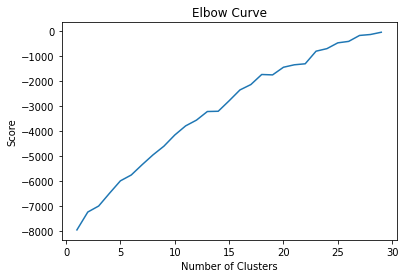

In [60]:
# Run a number of tests, for 1, 2, ... num_clusters
num_clusters = 30
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans_tests))]

# Plot the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

The curve show 4 to 5 clusters would do

It's Time for clustering of venues arround campuses

We create 5 clusters

In [61]:
# set number of clusters
kclusters = 5

us_campuses_grouped_clustering = us_campuses_grouped.drop('UScampuses', 1)

# run k-means clusterinS
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(us_campuses_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 3, 1, 3, 1, 1, 1, 1], dtype=int32)

Add latitude and longitude values by Merging the unique campus data to the sorted venues 

In [62]:
# add clustering labels
uscampus_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

uscampus_merged = unique_campuses

# merge uscampus_merged with uscampus_venues_sorted to add latitude/longitude for each campus
uscampus_merged = uscampus_merged.join(uscampus_venues_sorted.set_index('Name'), on='Name')

uscampus_merged.head() # check the last columns!

,GID_id,Name,Web_url,Address,Shape_length,Shape_area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Univ_016,Dominican House of Studies,http://www.dhs.edu,487 MICHIGAN AVENUE NE,753.638132,31647.864270,-76.997774,38.929879,3,Bookstore,Pharmacy,Grocery Store,Sandwich Place,Rental Car Location,Bar,Coffee Shop,Deli / Bodega,Art Gallery,Spa
12,Univ_023,Stanford in Washington,https://siw.stanford.edu/,2661 CONNECTICUT AVENUE NW,105.168729,448.839365,-77.051823,38.925304,1,Zoo Exhibit,Zoo,Mediterranean Restaurant,Sushi Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Bakery,Bar,Spa
16,Univ_011,Trinity College,http://www.trinitydc.edu/,125 MICHIGAN AVENUE NE,1573.000495,139712.005500,-77.001796,38.928818,3,Bookstore,Park,Grocery Store,Rental Car Location,Coffee Shop,Bus Stop,Bar,Pharmacy,Deli / Bodega,Sandwich Place
58,Univ_004,George Washington University at Mount Vernon C...,https://www.gwu.edu/mount-vernon-campus,2100 FOXHALL ROAD NW,1439.241902,91182.284910,-77.088793,38.919120,1,Pizza Place,Café,Trail,Mediterranean Restaurant,Sandwich Place,Farmers Market,Museum,Sushi Restaurant,Lake,Seafood Restaurant
164,Univ_010,Strayer University,http://www.strayer.edu/,1133 15TH STREET NW,397.966306,4375.199012,-77.013982,38.973461,1,American Restaurant,Vegetarian / Vegan Restaurant,Spa,Pizza Place,Middle Eastern Restaurant,Yoga Studio,Pharmacy,Sushi Restaurant,Brewery,Korean Restaurant


In [63]:
# import necessary packages for creating and formating maps
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm, colors
from matplotlib.colors import rgb2hex
import matplotlib as mpl

Generate map with markers

In [64]:
# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(uscampus_merged['Latitude'], uscampus_merged['Longitude'], uscampus_merged['Address'], uscampus_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=12,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
    ).add_to(map_clusters)
       
map_clusters

# Examining Clusters

Now, we can now examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we then assign a name to each cluster

Cluster: 1

In [65]:
cluster_1 = uscampus_merged.loc[uscampus_merged['Cluster Labels'] == 0, uscampus_merged.columns[[1] + list(range(5, uscampus_merged.shape[1]))]]

In [66]:

cluster_1

,Name,Shape_area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
233,Our Lady of Lebanon Maronite Seminary,3425.349051,-77.033965,38.977292,0,Liquor Store,Trail,Sandwich Place,Department Store,Donut Shop,Caribbean Restaurant,Bank,Park,Chinese Restaurant,Grocery Store
423,Howard University School of Divinity,126894.115300,-76.980287,38.939431,0,Park,Discount Store,Grocery Store,Liquor Store,Convenience Store,Bank,Pizza Place,Chinese Restaurant,Business Service,Bus Station
425,Marist College,9002.704145,-76.994988,38.943269,0,Convenience Store,Bus Stop,Park,Fast Food Restaurant,Bank,College Arts Building,College Bookstore,Latin American Restaurant,Sandwich Place,Food Service


Cluster: 2

In [67]:
cluster_2 = uscampus_merged.loc[uscampus_merged['Cluster Labels'] == 1, uscampus_merged.columns[[1] + list(range(5, uscampus_merged.shape[1]))]]

In [68]:
cluster_2

,Name,Shape_area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Stanford in Washington,448.839365,-77.051823,38.925304,1,Zoo Exhibit,Zoo,Mediterranean Restaurant,Sushi Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Bakery,Bar,Spa
58,George Washington University at Mount Vernon C...,91182.284910,-77.088793,38.919120,1,Pizza Place,Café,Trail,Mediterranean Restaurant,Sandwich Place,Farmers Market,Museum,Sushi Restaurant,Lake,Seafood Restaurant
164,Strayer University,4375.199012,-77.013982,38.973461,1,American Restaurant,Vegetarian / Vegan Restaurant,Spa,Pizza Place,Middle Eastern Restaurant,Yoga Studio,Pharmacy,Sushi Restaurant,Brewery,Korean Restaurant
244,Johns Hopkins University Paul H. Nitze School ...,4924.386930,-77.040222,38.907816,1,Hotel,Sandwich Place,Café,Steakhouse,Italian Restaurant,Salad Place,Coffee Shop,Mediterranean Restaurant,Pizza Place,Hotel Bar
246,Potomac College,1003.359500,-77.078918,38.950249,1,Pizza Place,Coffee Shop,Gym / Fitness Center,Yoga Studio,Dance Studio,American Restaurant,Convenience Store,Bank,Pharmacy,Mexican Restaurant
251,Les Aspin Center for Government,243.989591,-76.999152,38.890031,1,Park,Library,Coffee Shop,American Restaurant,Bookstore,Pizza Place,Spa,Gift Shop,Market,Liquor Store
256,Cornell in Washington,585.289590,-77.048293,38.908285,1,Hotel,Café,Park,Hotel Bar,Sandwich Place,Pizza Place,French Restaurant,History Museum,Japanese Restaurant,Thai Restaurant
274,Syracuse University,285.697071,-77.050568,38.923844,1,Zoo Exhibit,Hotel,Mediterranean Restaurant,Sushi Restaurant,Zoo,Ice Cream Shop,Bakery,Bar,Spa,Coffee Shop
280,University of California Washington Center,1610.124667,-77.037186,38.906328,1,Hotel,Coffee Shop,Sandwich Place,Steakhouse,Hotel Bar,Pizza Place,Seafood Restaurant,American Restaurant,Salad Place,Gym / Fitness Center
290,Howard University Law School,80360.873360,-77.057143,38.942137,1,Italian Restaurant,Thai Restaurant,Sandwich Place,Trail,Mediterranean Restaurant,Bank,Pizza Place,Rental Car Location,Mexican Restaurant,Indian Restaurant


Cluster: 3

In [69]:
cluster_3 = uscampus_merged.loc[uscampus_merged['Cluster Labels'] == 2, uscampus_merged.columns[[1] + list(range(5, uscampus_merged.shape[1]))]]

In [70]:
cluster_3

,Name,Shape_area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
267,American University Washington College of Law,3869.924388,-77.094505,38.945140,2,Coffee Shop,Bank,Deli / Bodega,Pizza Place,Bakery,Seafood Restaurant,Tea Room,Tennis Court,Church,Furniture / Home Store
354,American University,403294.779400,-77.090299,38.940895,2,Coffee Shop,Bus Stop,Bank,Park,Pharmacy,Italian Restaurant,Shopping Mall,Tennis Court,Student Center,Burger Joint


Cluster: 4

In [71]:
cluster_4 = uscampus_merged.loc[uscampus_merged['Cluster Labels'] == 3, uscampus_merged.columns[[1] + list(range(5, uscampus_merged.shape[1]))]]

In [72]:
cluster_4

,Name,Shape_area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dominican House of Studies,31647.86427,-76.997774,38.929879,3,Bookstore,Pharmacy,Grocery Store,Sandwich Place,Rental Car Location,Bar,Coffee Shop,Deli / Bodega,Art Gallery,Spa
16,Trinity College,139712.00550,-77.001796,38.928818,3,Bookstore,Park,Grocery Store,Rental Car Location,Coffee Shop,Bus Stop,Bar,Pharmacy,Deli / Bodega,Sandwich Place
166,Saint Paul's College,38420.59193,-76.997937,38.928253,3,Rental Car Location,Sandwich Place,Bookstore,Pharmacy,Burger Joint,Gym / Fitness Center,Pizza Place,Mexican Restaurant,Coffee Shop,Bus Stop
285,Theological College,20057.83359,-77.000436,38.931360,3,Coffee Shop,Food Truck,American Restaurant,Bar,Art Gallery,Sandwich Place,Deli / Bodega,Food Court,Latin American Restaurant,Food Service
352,Howard University,406569.00510,-77.020351,38.926227,3,Coffee Shop,Food Truck,Seafood Restaurant,Sandwich Place,Beer Garden,Music Venue,Deli / Bodega,Mexican Restaurant,Pizza Place,Park
438,Catholic University of America,614563.69060,-76.998379,38.940296,3,Bus Stop,Bookstore,Bar,Art Gallery,Coffee Shop,Convenience Store,Sandwich Place,Pharmacy,College Cafeteria,College Rec Center


Cluster: 5

In [73]:
cluster_5 = uscampus_merged.loc[uscampus_merged['Cluster Labels'] == 4, uscampus_merged.columns[[1] + list(range(5, uscampus_merged.shape[1]))]]

In [74]:
cluster_5

,Name,Shape_area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
345,National Defense University,31092.87296,-77.014765,38.864754,4,Gym,Pizza Place,Playground,Volleyball Court,Liquor Store,Souvenir Shop,Brewery,General Entertainment,Park,Boat or Ferry


# Principal Components Analysis 

Principal component helps to interprete the result of our cluster.

Remember We began by selecting helpful columns for the PCA from our previous dummy dataframe

df = uscampus_onehot.groupby('UScampuses').mean()
df.head()

In [75]:
# import library for PCA 
from sklearn.decomposition import PCA

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Transfor the scaled data to the new PCA space
X_reduced = pca.transform(X_scaled)

In [76]:
clusters =  kmeans.predict(X_scaled)

In [77]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index=df.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = clusters
X_reduceddf.head()

,PC1,PC2,cluster
UScampuses,,,
"ASU in Washington, DC",6.442946,1.105002,1
American University,-3.673344,-0.839594,2
American University Washington College of Law,-3.548563,-0.958021,2
Catholic University of America,-5.974971,-1.142668,3
Cornell in Washington,5.708688,-2.782693,1


In [78]:
centres_reduced = pca.fit_transform(kmeans.cluster_centers_)

In [82]:
#!pip install seaborn
#!pip install seaborn
print('installatiion complete')

installatiion complete


In [83]:
# seaborn library for  creating plots
import seaborn as sns; sns.set()

Check the shape the  X-scaled and X_reduced

In [84]:
X_scaled.shape

(30, 265)

In [85]:
X_reduced.shape

(30, 2)

create a scatter plot of the components dataframe

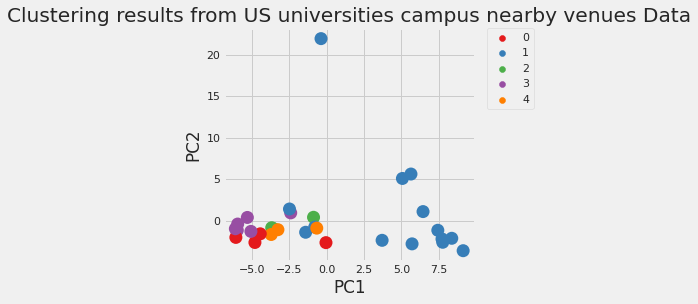

In [99]:
# create a scatter plot 
plt.style.use("fivethirtyeight")
plt.figure(figsize=(4, 4))
scat = sns.scatterplot(
        "PC1",
        "PC2",
       
        data=X_reduceddf,
        hue="cluster",
        palette="Set1",
        edgecolor='none',
        s=169, linewidths=3,
        zorder=10
)
   
scat.set_title(
        "Clustering results from US universities campus nearby venues Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
   
plt.show()

The scatter plot of our  clusters shows their are some overlapping of the clusters an outlier 

## Results Discussion: 

We need to interprete and visualize our clusters

In [100]:
# Import relevant packages for creating word cloud 
#!conda install -c conda-forge wordcloud --yes
#!conda install -c conda-forge pillow --yes
#!pip install wordcloud
#!pip install pillow
print('installation complete')
from PIL import Image
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
import itertools
import collections
print('import complete')

installation complete
import complete


In [101]:
# Get selected column range and save as numpy array
numpy_array = cluster_1[cluster_1.columns[5:15]].to_numpy()

# Save it as text file
np.savetxt("cluster_test_file1.txt", numpy_array, fmt = "%r")

In [102]:
# Read the text file
text = open('cluster_test_file1.txt', 'r').read()

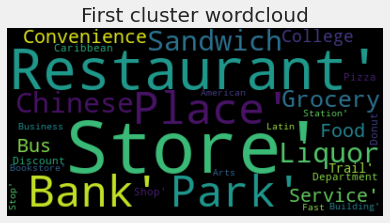

In [103]:
# geberate a wordcloud of the first cluster
wordcloud1 = WordCloud().generate(text)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('First cluster wordcloud')
plt.show()

In [104]:
from collections import Counter
text

"'Liquor Store' 'Trail' 'Sandwich Place' 'Department Store' 'Donut Shop' 'Caribbean Restaurant' 'Bank' 'Park' 'Chinese Restaurant' 'Grocery Store'\n'Park' 'Discount Store' 'Grocery Store' 'Liquor Store' 'Convenience Store' 'Bank' 'Pizza Place' 'Chinese Restaurant' 'Business Service' 'Bus Station'\n'Convenience Store' 'Bus Stop' 'Park' 'Fast Food Restaurant' 'Bank' 'College Arts Building' 'College Bookstore' 'Latin American Restaurant' 'Sandwich Place' 'Food Service'\n"

In [105]:
# Converting string to list 
import re
res = text.strip('/\n"').split(', ') 
  
# printing final result and its type 
print ("final list", res) 
print (type(res)) 

final list ["'Liquor Store' 'Trail' 'Sandwich Place' 'Department Store' 'Donut Shop' 'Caribbean Restaurant' 'Bank' 'Park' 'Chinese Restaurant' 'Grocery Store'\n'Park' 'Discount Store' 'Grocery Store' 'Liquor Store' 'Convenience Store' 'Bank' 'Pizza Place' 'Chinese Restaurant' 'Business Service' 'Bus Station'\n'Convenience Store' 'Bus Stop' 'Park' 'Fast Food Restaurant' 'Bank' 'College Arts Building' 'College Bookstore' 'Latin American Restaurant' 'Sandwich Place' 'Food Service'"]
<class 'list'>


In [106]:
from collections import Counter

counter = Counter(res)
print(counter)

Counter({"'Liquor Store' 'Trail' 'Sandwich Place' 'Department Store' 'Donut Shop' 'Caribbean Restaurant' 'Bank' 'Park' 'Chinese Restaurant' 'Grocery Store'\n'Park' 'Discount Store' 'Grocery Store' 'Liquor Store' 'Convenience Store' 'Bank' 'Pizza Place' 'Chinese Restaurant' 'Business Service' 'Bus Station'\n'Convenience Store' 'Bus Stop' 'Park' 'Fast Food Restaurant' 'Bank' 'College Arts Building' 'College Bookstore' 'Latin American Restaurant' 'Sandwich Place' 'Food Service'": 1})


Our first cluster shows eatries, lodges, relaxation  spots are a good business because it shows Restaurants, Bar, Hotel, coffee shop and fitness center

In [107]:
# Get selected column range and save as numpy array
numpy_array = cluster_2[cluster_2.columns[5:15]].to_numpy()

# Save it as text file
np.savetxt("cluster_test_file2.txt", numpy_array, fmt = "%r")

In [108]:
# Read the text file
text2 = open('cluster_test_file2.txt', 'r').read()

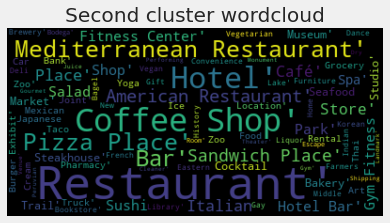

In [109]:
# geberate a wordcloud of the second cluster
wordcloud2 = WordCloud().generate(text2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('Second cluster wordcloud')
plt.show()

The second cluster shows eatries, shoping center, relaxation spots and medical facility could be a good business because it shows Restaurants, store, Bar, coffee shop and pharmacy

In [110]:
# Get selected column range and save as numpy array
numpy_array = cluster_3[cluster_3.columns[5:15]].to_numpy()

# Save it as text file
np.savetxt("cluster_test_file3.txt", numpy_array, fmt = "%r")

In [111]:
# Read the text file
text3 = open('cluster_test_file3.txt', 'r').read()

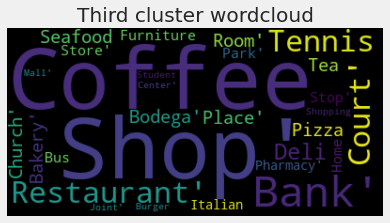

In [112]:
# geberate a wordcloud of the third cluster
wordcloud3 = WordCloud().generate(text3)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis('off')
plt.title('Third cluster wordcloud')
plt.show()

The third cluster shows shoping center, relaxation spots and convenience facility could be a good business because it shows store, park, discount, convenience shop and Restaurant

In [113]:
# Get selected column range and save as numpy array
numpy_array = cluster_4[cluster_4.columns[5:15]].to_numpy()

# Save it as text file
np.savetxt("cluster_test_file4.txt", numpy_array, fmt = "%r")

In [114]:
# Read the text file
text4 = open('cluster_test_file4.txt', 'r').read()

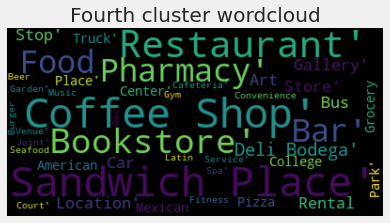

In [115]:
# geberate a wordcloud of the fourth cluster
wordcloud4 = WordCloud().generate(text4)
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis('off')
plt.title('Fourth cluster wordcloud')
plt.show()

The fourth cluster shows shoping center, fitness center, relaxation spots and sporting facility could be a good business because it shows store, gym pizza, and sporting 

In [116]:
# Get selected column range and save as numpy array
numpy_array = cluster_5[cluster_5.columns[5:15]].to_numpy()

# Save it as text file
np.savetxt("cluster_test_file5.txt", numpy_array, fmt = "%r")

In [117]:
# Read the text file
text5 = open('cluster_test_file5.txt', 'r').read()

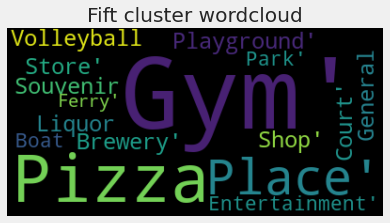

In [118]:
# geberate a wordcloud of the fift cluster
wordcloud5 = WordCloud().generate(text5)
plt.imshow(wordcloud5, interpolation='bilinear')
plt.axis('off')
plt.title('Fift cluster wordcloud')
plt.show()

The fift cluster shows shoping center, relaxation spots, financial institutions and educational facilities could be a good business because it shows coffee, shop, bankt, furniture shop, college and Restaurant

Let's find out why restaurants keep showing up in each cluster by showing how they compare with one another

In [119]:
# Select expected columns from our lager uscampus_merged and convert it to a numpy array
numpy_array = uscampus_merged[uscampus_merged.columns[9:19]].to_numpy()

# Save it as text file
np.savetxt("campust_top_10.txt", numpy_array, fmt = "%r")

In [120]:
# Read the text file
all_text = open('campust_top_10.txt', 'r').read()

In [127]:
# Open the file in read mode 
text = open("campust_top_10.txt", "r") 
  
# Create an empty dictionary 
d = dict() 
  
# Loop through each line of the file 
for line in text: 
    # Remove the leading spaces and newline character 
    line = line.strip() 
  
    # Convert the characters in line to  
    # lowercase to avoid case mismatch 
    line = line.lower() 
  
    # Split the line into words 
    words = line.split(" ") 
  
    # Iterate over each word in line 
    for word in words: 
        # Check if the word is already in dictionary 
        if word in d: 
            # Increment count of word by 1 
            d[word] = d[word] + 1
        else: 
            # Add the word to dictionary with count 1 
            d[word] = 1
  
# Print the contents of dictionary 
for key in list(d.keys()): 
    print(key, ":", d[key]) 

'bookstore' : 5
'pharmacy' : 7
'grocery : 6
store' : 19
'sandwich : 16
place' : 38
'rental : 5
car : 5
location' : 5
'bar' : 8
'coffee : 19
shop' : 26
'deli : 6
/ : 16
bodega' : 6
'art : 4
gallery' : 3
'spa' : 5
'zoo : 2
exhibit' : 2
'zoo' : 2
'mediterranean : 10
restaurant' : 58
'sushi : 5
'hotel' : 10
'ice : 2
cream : 2
'bakery' : 4
'park' : 12
'bus : 6
stop' : 5
'pizza : 15
'café' : 6
'trail' : 4
'farmers : 1
market' : 1
'museum' : 1
'lake' : 1
'seafood : 5
'american : 9
'vegetarian : 1
vegan : 1
'middle : 1
eastern : 1
'yoga : 2
studio' : 3
'brewery' : 2
'korean : 1
'burger : 4
joint' : 4
'gym : 6
fitness : 6
center' : 8
'mexican : 4
'liquor : 4
'department : 1
'donut : 1
'caribbean : 1
'bank' : 7
'chinese : 2
'steakhouse' : 3
'italian : 8
'salad : 5
'hotel : 5
bar' : 10
'dance : 1
'convenience : 4
'library' : 1
'gift : 1
'market' : 2
'french : 1
'history : 1
museum' : 2
'japanese : 2
'thai : 2
'tea : 1
room' : 2
'tennis : 2
court' : 4
'church' : 1
'furniture : 2
home : 2
'food : 7

In [128]:
df = pd.DataFrame(list(d.items()),columns = ['Word','Count']) 

In [129]:
df.sort_values(by=['Count'],ascending=False, inplace=True)

In [130]:
# save top 20
top20=df.head(20)

In [133]:
# drop rows that don't make meaning 
top20.drop([13,5,21,61,52], inplace=True) # view the dataframe 

In [134]:
top20

,Word,Count
22,restaurant',58
11,shop',26
10,'coffee,19
3,store',19
4,'sandwich,16
31,'pizza,15
28,'park',12
64,bar',10
24,'hotel',10
39,'american,9


Text(0.5, 1.0, 'Top 20 most frequent venues')

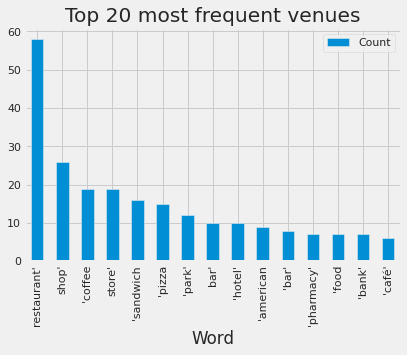

In [135]:
# Plot the graph of the top 20 most frequent venues
top20.plot.bar(x='Word',y='Count')
plt.title('Top 20 most frequent venues')

SUMMARY/CONCLUSION

Results as seen from venues around United States colleges and University campuses shows that:

1. Any kind of relaxation spot is a lucrative business around a university campus.
2. The campuses are almost over loaded with restaurants which tells us that one is bound to face huge competitions. so you could decide to go for less competitive business venture like  coffee shop
3. Next to relaxation spots is eateries and shopping centers
4. Some ventures that may not be common but not less lucrative could be financial institutions (bank), medical facilities (pharmacy) and fitness facilities (gym)
5. Coffee shops appear  to be  an easy and less capital intensive business venture to invest in.
6. Further analysis could be embarked on to have two words processing so we could have something like ‘coffee shops’ not just ‘coffee’  to see if one word processing had any negative effect on the results. 


Gospel Saloka-ondenma
Data Analyst